### Формулювання задачі 9

In [1]:
#Для початку сформулюємо нашу задачу за допомогою функції LaTex
from IPython.display import display, Math

# Створення текстового представлення умови задачі у вигляді LaTeX
task_description = r"""
\text{Знайти чисельний розв'язок еліптичного рівняння математичної фізики (прогин плівки, стаціонарна теплопровідність):}
$$
\frac{\partial^2 U}{\partial x^2} + 2 \frac{\partial^2 U}{\partial y^2} - 4U = e^{-\sin(xy)}, \quad (x, y) \in [-1, 1]^2.
$$
\text{Граничні умови:}
$$
\frac{\partial U}{\partial x}\bigg|_{(-1, y)} = y^2 - 1, \quad U(1, y) = 1,
$$
$$
\frac{\partial U}{\partial y}\bigg|_{(x, -1)} = 3, \quad U(x, 1) = x^2 + 1.
$$
"""

# Відображення умови задачі
display(Math(task_description))

<IPython.core.display.Math object>

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import time

from block_thomas_method import BlockThomas
from adi_method import ADIMethod
from sor_method import SORMethod

### Визначення граничних умов

In [36]:
# Визначення параметрів для диференціальних рівнянь по осі абсцис x
x_params = {
    'func': lambda x, y: np.ones_like(x),  # Функція для коефіцієнта A(x, y)
    'interval': (-1, 1),  # Інтервал для змінних по x
    'boundary_cond': [
        (1, 0, lambda y: y**2 - 1),  # Ліва границя (умова Неймана) : похідна дорівнює y^2 - 1 
        (0, 1, lambda y: np.ones_like(y))  # Права границя (умова Діріхле): значення дорівнює 1
    ],
    'grid_points': 100  # Кількість точок на сітці по x
}

# Визначення параметрів для диференціальних рівнянь по осі ординат y
y_params = {
    'func': lambda x, y: np.full_like(x, 2),  # Функція для коефіцієнта B(x, y)
    'interval': (-1, 1),  # Інтервал для змінних по y
    'boundary_cond': [
        (1, 0, lambda x: np.full_like(x, 3)),  # Нижня границя (умова Неймана): похідна дорівнює 3
        (0, 1, lambda x: x**2 + 1)  # Верхня границя (умова Діріхле): значення дорівнює x^2 + 1
    ],
    'grid_points': 100  # Кількість точок на сітці по y
}

In [38]:
# Опис правої частини рівняння
C = lambda x, y: np.full_like(x, -4)  # Функція для коефіцієнта С(x, y)
G = lambda x, y: np.exp(-np.sin(x * y))  # Функція для правої частини рівняння G(x, y)

### Реалізація методу матричної прогонки (BlockThomas), поздовжньо-поперечної прогонки (ADI) та релаксації (SOR)

In [50]:
# Реалізація методу матричної прогонки (BlockThomas)
solver = BlockThomas(x_params, y_params, C, G)
U_block = solver.solve()

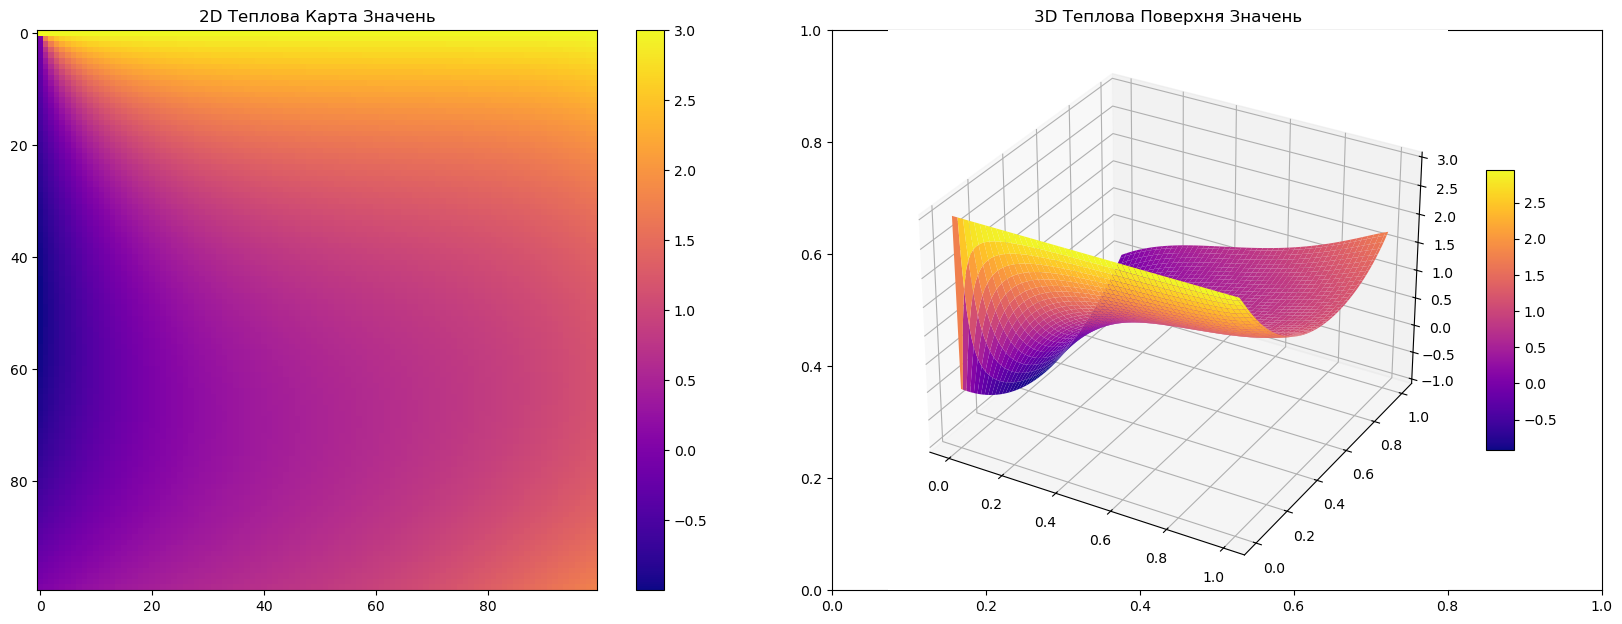

In [52]:
# Візуалізація результатів у 2D та 3D
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 2D теплове зображення
heatmap = axes[0].imshow(U_block, cmap='plasma')  
fig.colorbar(heatmap, ax=axes[0], orientation='vertical')
axes[0].set_title('2D Теплова Карта Значень')

# Налаштування для 3D графіка
ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
x_values = np.linspace(0, 1, U_block.shape[1])  
y_values = np.linspace(0, 1, U_block.shape[0])
x_values, y_values = np.meshgrid(x_values, y_values)
surface_plot = ax_3d.plot_surface(x_values, y_values, U_block, cmap='plasma')  
fig.colorbar(surface_plot, ax=ax_3d, shrink=0.5, aspect=10)
ax_3d.set_title('3D Теплова Поверхня Значень')

# Збільшення відступів між графіками
fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15)
plt.show()

З отриманих результатів бачимо, що метод матричної прогонки реалізовується. На 2D тепловій карті відбувається плавний перехід, що означає, що рівняння розв'язано правильно. На 3D поверхні відсутні "зазубринки" на границі, а значить граничні умови правильно імплементовані. Нижче реалізуємо методи ADI та SOR.

In [44]:
#Реалізація методу поздовжньо-поперечної прогонки (ADIMethod)
adi = ADIMethod(x_params, y_params, C, G, internal_conditions=[])
U_adi = adi.solve(max_iterations=20000, accuracy_threshold=1e-7)

In [45]:
#Реалізація методу релаксації (SORMethod)
relaxation = SORMethod(x_params, y_params, C, G, internal_conditions=[])
U_relax = relaxation.solve(max_iterations=20000, accuracy_threshold=1e-7)

### Візуалізація значень різних методів на одній системі координат

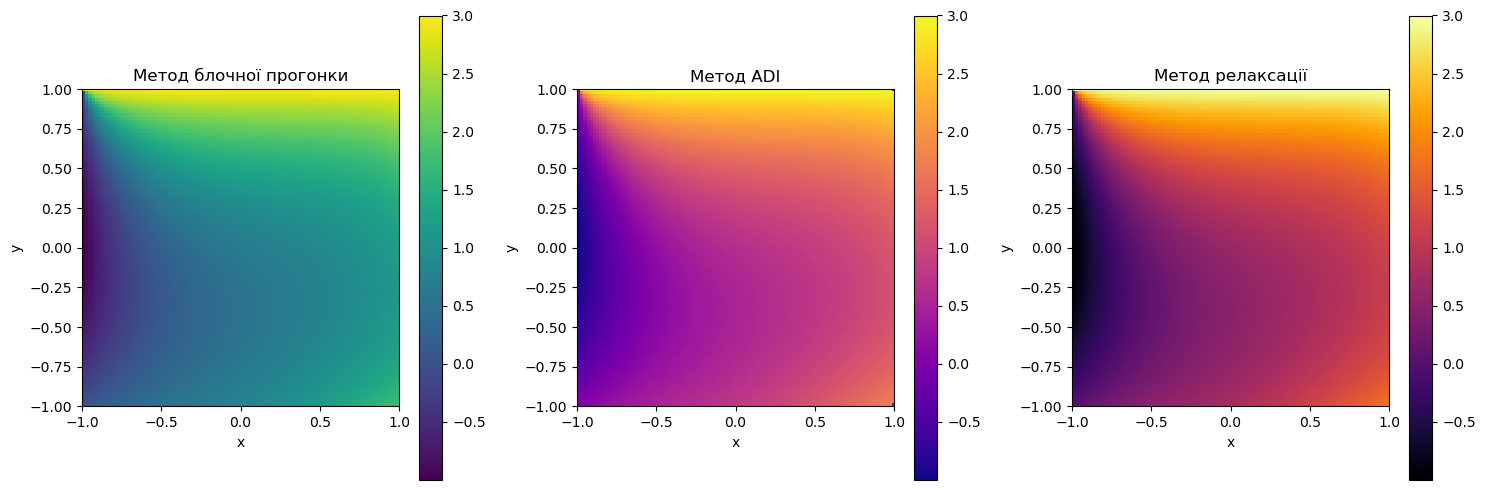

In [58]:
# Візуалізація результатів у 2D
plt.figure(figsize=(15, 5))

# Візуалізація значень методу блочної тридіагональної прогонки
plt.subplot(1, 3, 1)
plt.imshow(U_block, cmap='viridis', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.title("Метод блочної прогонки")
plt.xlabel("x")
plt.ylabel("y")

# Візуалізація значень методу поздовжньо-попереіної прогонки ADI
plt.subplot(1, 3, 2)
plt.imshow(U_adi, cmap='plasma', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.title("Метод ADI")
plt.xlabel("x")
plt.ylabel("y")

# Візуалізація значень методу релаксації
plt.subplot(1, 3, 3)
plt.imshow(U_relax, cmap='inferno', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.title("Метод релаксації")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

Отриманні результати на графіках вказують на те, що приблизно всі методи дають однаковий результат, обчислимо більше показників, щоб порівняти методи за часом їх виконання та точністю.

### Порівняння методів за часом виконання та точністю

In [80]:
# Вимірювання часу роботи методу матричної прогонки
work_time_matrix = time.time()
U_block = solver.solve()
work_time_matrix = time.time() - work_time_matrix
print(f"Час виконання методу матричної прогонки: {work_time_matrix:.2f} сек")

# Вимірювання часу роботи методу ADI
work_time_adi = time.time()
U_adi = adi.solve(max_iterations=20000, accuracy_threshold=1e-7)
work_time_adi = time.time() - work_time_adi
print(f"Час виконання методу поздовжньо-поперечної прогонки: {work_time_adi:.2f} сек")

# Вимірювання часу роботи методу SOR
work_time_relax = time.time()
U_relax = relaxation.solve(max_iterations=20000, accuracy_threshold=1e-7)
work_time_relax = time.time() - work_time_relax
print(f"Час виконання методу релаксації: {work_time_relax:.2f} сек") 

Час виконання методу матричної прогонки: 0.31 сек
Час виконання методу поздовжньо-поперечної прогонки: 55.52 сек
Час виконання методу релаксації: 58.21 сек


In [85]:
#Вимірювання точності чисельних методів 
print("MAE(BlockThomas, ADIMethod) =", np.mean(np.abs(U_block - U_adi)))
print("MAE(BlockThomas, SORMethod) =", np.mean(np.abs(U_block - U_relax)))

MAE(BlockThomas, ADIMethod) = 0.0007862008749599036
MAE(BlockThomas, SORMethod) = 1.4942985400364773e-05


### Висновок

У файлі task_9_solved подано розв'язок еліптичного рівняння математичної фізики, сформувальованого у завданні 9. У ході роботи було реалізовано:
1. Програмно методи матричної прогонки (BlockThomas), поздовжньо-поперечної прогонки (ADI) та релаксації (SOR). При чому вибрано метод релаксації, а не метод Зейделя через можливість зручного налаштування релаксаційного критерія w (omega), що допомагає швидше досягти збіжності (критична умова для задач еліптичного рівняння).
2. Визначено чітко граничні умови. У задачі присутні умова Діріхле та умова Неймана
3. Візуальна реалізація методів показала, що знайдено правильной розв'язок рівнянь.
4. Порівняння методів за швидкістю показали, що метод матричної прогонки значно випереджає два інших методи.
5. Крім того, методи також порівняли за параметром точності. Еталонним значенням вибрано матричної прогонки, оскільки цей метод є прямим методом розв'язання системи лінійних рівнянь. Він не використовує ітерацій і, при коректній реалізації, дає точний розв'язок з обмеженими похибками, пов'язаними лише з числовою точністю обчислень на машині. Відповідно за допомогою обчислення абсолютної похибки відносно методу матричної прогонки було встановлено, що метод релаксації ближче наближається до точного розв'язку, ніж метод поздовжньо-поперечної прогонки.

**Отже, найбільш ефективним по швидкості і точності розв'язку еліптичного рівняння є метод матричної прогонки (BlockThomas), компромісом між швидкістю і точністю є метод поздовжньо-поперечної прогонки ADI (менший час, але менш точний розв'язок) та метод релаксації SOR (довший час, але точніший розв'язок).**